## Imports

In [1]:
pip install iterative-stratification

In [2]:
import pandas as pd
import re
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [3]:
from google.colab import userdata
#userdata.get('wandb')

In [4]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [6]:
data = pd.read_csv('/content/drive/MyDrive/subtask2/train/eng.csv')
dev = pd.read_csv('/content/drive/MyDrive/subtask2/dev/eng.csv')

In [7]:
data

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0
...,...,...,...,...,...,...,...
3217,eng_d7af338f325fcc12d4c107c591c64a19,the internalized xenophobia seething fr ppl sh...,0,0,0,0,0
3218,eng_8371147528d6f09acbe9b647c8fa5eb7,the radical left hates chick peas,1,0,0,0,0
3219,eng_4d188ccdfb84eeeaed31b7f28af538ca,this is how xenophobia and misogyny looks like,1,0,0,1,0
3220,eng_867cc5be4f80dafae67ab5f0f70a1ee8,yeah and committing war crimes,0,0,0,0,0


political        1150
racial/ethnic     281
other             126
religious         112
gender/sexual      72
dtype: int64
political        35.69
racial/ethnic     8.72
other             3.91
religious         3.48
gender/sexual     2.23
dtype: float64


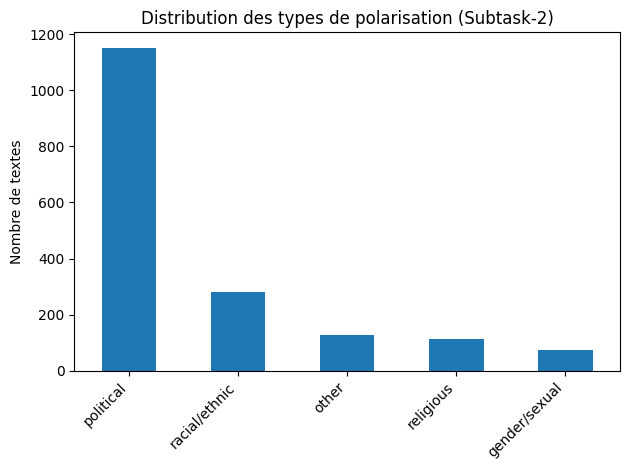

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
label_counts = data[label_cols].sum().sort_values(ascending=False)
print(label_counts)
label_percent = (label_counts / len(data)) * 100
print(label_percent.round(2))
plt.figure()
label_counts.plot(kind="bar")
plt.title("Distribution des types de polarisation (Subtask-2)")
plt.ylabel("Nombre de textes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [9]:
data["is_polarized"] = data[label_cols].sum(axis=1) > 0

non_polarized_count = (~data["is_polarized"]).sum()
polarized_count = data["is_polarized"].sum()

print("Polarized text:", polarized_count)
print("Non-polarized text:", non_polarized_count)
print("Non-polarized percentage:", round(non_polarized_count / len(data) * 100, 2), "%")


Polarized text: 1175
Non-polarized text: 2047
Non-polarized percentage: 63.53 %


In [10]:
data["num_labels"] = data[label_cols].sum(axis=1)
data["num_labels"].value_counts().sort_index()
(data["num_labels"].value_counts(normalize=True) * 100).sort_index().round(2)
co_occurrence = pd.DataFrame(
    0, index=label_cols, columns=label_cols
)

for col1 in label_cols:
    for col2 in label_cols:
        co_occurrence.loc[col1, col2] = ((data[col1] == 1) & (data[col2] == 1)).sum()

print(co_occurrence)


               political  racial/ethnic  religious  gender/sexual  other
political           1150            269        104             68    120
racial/ethnic        269            281         77             21     30
religious            104             77        112              8     10
gender/sexual         68             21          8             72     13
other                120             30         10             13    126


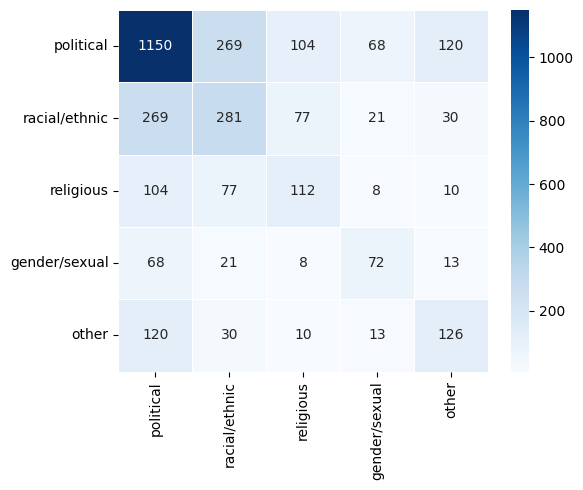

In [11]:
import seaborn as sns

co_occurrence = data[label_cols].T.dot(data[label_cols])  # co-occurrence matrix

plt.figure(figsize=(6,5))
sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.tight_layout()
plt.savefig("cooccurrence_eng.pdf", bbox_inches="tight")
plt.show()


In [12]:
data["text_length"] = data["text"].str.split().str.len()
data.groupby("is_polarized")["text_length"].describe()

,count,mean,std,min,25%,50%,75%,max
is_polarized,,,,,,,,
False,2047.0,11.297020,7.471137,5.0,7.0,9.0,13.0,60.0
True,1175.0,13.940426,8.645381,4.0,8.0,12.0,17.0,57.0


### Data clean

In [13]:
def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"[^a-z0-9.,?!' ]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t
data = data.copy()
dev = dev.copy()
data["text"] = data["text"].apply(clean_text)
dev["text"] = dev["text"].apply(clean_text)


### Slit Data

In [14]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]

X = data
y = data[label_cols].values

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=2
)

train_idx, val_idx = next(msss.split(X, y))

train = data
val = data.iloc[val_idx].reset_index(drop=True)


# =============================================================
APPROACH 1: 3 SEPARATE MODELS

*   Model A1_1: Multi-label for ["political", "racial/ethnic", "religious"]
*   Model A1_2: Binary for ["gender/sexual"]
*   Model A1_3: Binary for ["other"]

# =============================================================

In [15]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [16]:
# ============================================================
# APPROACH 1: 3 SEPARATE MODELS
# ============================================================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

# ============================================================
# UTILITIES
# ============================================================

class A1_WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.pos_weights).to(logits.device) if self.pos_weights else None
        )
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def A1_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    if probs.ndim == 1 or probs.shape[1] == 1:
        probs = probs.flatten()
        labels = labels.flatten()

        best_f1, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_threshold = f1, threshold

        preds_best = (probs > best_threshold).astype(int)
        return {
            'f1': best_f1,
            'precision': precision_score(labels, preds_best, zero_division=0),
            'recall': recall_score(labels, preds_best, zero_division=0),
            'threshold': best_threshold
        }
    else:
        best_f1_macro, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, average='macro', zero_division=0)
            if f1 > best_f1_macro:
                best_f1_macro, best_threshold = f1, threshold

        return {'f1_macro': best_f1_macro, 'threshold': best_threshold}

def A1_train_model(label_list, output_dir, epochs=5, lr=2e-5):
    """Train a model for given labels"""
    num_labels = len(label_list)

    # Compute pos_weights
    pos_weights = []
    print(f"\nClass weights for {output_dir}:")
    for label in label_list:
        y_train = train[label].values
        weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        pos_weight = weights[1] / weights[0]
        pos_weights.append(pos_weight)
        n_pos = y_train.sum()
        print(f"  {label:20s}: pos_weight={pos_weight:.3f} ({n_pos}/{len(y_train)} = {n_pos/len(y_train)*100:.1f}%)")

    # Create model
    config = AutoConfig.from_pretrained(A1_model_name)
    config.num_labels = num_labels
    config.problem_type = "multi_label_classification"
    model = AutoModelForSequenceClassification.from_pretrained(A1_model_name, config=config)
    model.to(device)

    # Create datasets
    train_dataset = PolarizationDataset(
        train['text'].tolist(),
        train[label_list].values.tolist(),
        A1_tokenizer
    )
    val_dataset = PolarizationDataset(
        val['text'].tolist(),
        val[label_list].values.tolist(),
        A1_tokenizer
    )

    # Training args
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1" if num_labels == 1 else "f1_macro",
        greater_is_better=True,
        logging_steps=50,
        warmup_ratio=0.1,
        weight_decay=0.01,
        save_total_limit=2,
        seed=42,
    )

    # Train
    trainer = A1_WeightedBCETrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=A1_compute_metrics,
        data_collator=DataCollatorWithPadding(A1_tokenizer),
        pos_weights=pos_weights
    )

    print(f"\nTraining {output_dir}...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\nResults {output_dir}:")
    for key, value in eval_results.items():
        print(f"  {key}: {value}")

    return trainer, val_dataset

# ============================================================
# TRAIN MODELS
# ============================================================

print("="*70)
print("APPROACH 1: 3 SEPARATE MODELS")
print("="*70)

A1_model_name = 'roberta-base'
A1_tokenizer = AutoTokenizer.from_pretrained(A1_model_name)

# Model 1: Multi-label [political, racial/ethnic, religious]
A1_trainer_m1, A1_val_ds_m1 = A1_train_model(
    ["political", "racial/ethnic", "religious"],
    './A1_results_m1',
    epochs=5,
    lr=2e-5
)

# Model 2: Binary [gender/sexual]
A1_trainer_m2, A1_val_ds_m2 = A1_train_model(
    ["gender/sexual"],
    './A1_results_m2',
    epochs=4,
    lr=3e-5
)

# Model 3: Binary [other]
A1_trainer_m3, A1_val_ds_m3 = A1_train_model(
    ["other"],
    './A1_results_m3',
    epochs=5,
    lr=2e-5
)

# ============================================================
# COMBINE PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("COMBINING 3 MODELS")
print("="*70)

# Get predictions
A1_logits_m1 = A1_trainer_m1.predict(A1_val_ds_m1).predictions
A1_labels_m1 = A1_trainer_m1.predict(A1_val_ds_m1).label_ids
A1_logits_m2 = A1_trainer_m2.predict(A1_val_ds_m2).predictions
A1_labels_m2 = A1_trainer_m2.predict(A1_val_ds_m2).label_ids
A1_logits_m3 = A1_trainer_m3.predict(A1_val_ds_m3).predictions
A1_labels_m3 = A1_trainer_m3.predict(A1_val_ds_m3).label_ids

# Reshape if needed
if A1_logits_m2.ndim == 1:
    A1_logits_m2 = A1_logits_m2.reshape(-1, 1)
    A1_labels_m2 = A1_labels_m2.reshape(-1, 1)
if A1_logits_m3.ndim == 1:
    A1_logits_m3 = A1_logits_m3.reshape(-1, 1)
    A1_labels_m3 = A1_labels_m3.reshape(-1, 1)

# Combine
A1_combined_logits = np.concatenate((A1_logits_m1, A1_logits_m2, A1_logits_m3), axis=1)
A1_combined_labels = np.concatenate((A1_labels_m1, A1_labels_m2, A1_labels_m3), axis=1)
A1_combined_probs = torch.sigmoid(torch.tensor(A1_combined_logits)).numpy()

print(f"Combined shape: {A1_combined_probs.shape}")

# Find optimal thresholds
A1_label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
A1_best_thresholds = []

print("\nOptimal thresholds:")
for i, label in enumerate(A1_label_cols):
    best_f1, best_threshold = 0, 0.5
    for threshold in np.arange(0.2, 0.8, 0.05):
        preds = (A1_combined_probs[:, i] > threshold).astype(int)
        f1 = f1_score(A1_combined_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
    A1_best_thresholds.append(best_threshold)
    print(f"  {label:20s}: {best_threshold:.2f} (F1={best_f1:.3f})")

# Apply thresholds
A1_combined_preds = np.zeros_like(A1_combined_probs)
for i in range(5):
    A1_combined_preds[:, i] = (A1_combined_probs[:, i] > A1_best_thresholds[i]).astype(int)

# ============================================================
# FINAL RESULTS
# ============================================================

print("\n" + "="*70)
print("APPROACH 1 - FINAL RESULTS")
print("="*70)

A1_f1_macro = f1_score(A1_combined_labels, A1_combined_preds, average='macro', zero_division=0)
print(f"\nMacro F1: {A1_f1_macro:.4f}")

print(f"\n{'Label':<20} {'Model':<10} {'F1':<8} {'Prec':<8} {'Recall':<8} {'Threshold':<10}")
print("-" * 70)

A1_model_map = ["M1", "M1", "M1", "M2", "M3"]
for i, label in enumerate(A1_label_cols):
    f1 = f1_score(A1_combined_labels[:, i], A1_combined_preds[:, i], zero_division=0)
    prec = precision_score(A1_combined_labels[:, i], A1_combined_preds[:, i], zero_division=0)
    rec = recall_score(A1_combined_labels[:, i], A1_combined_preds[:, i], zero_division=0)
    print(f"{label:<20} {A1_model_map[i]:<10} {f1:<8.3f} {prec:<8.3f} {rec:<8.3f} {A1_best_thresholds[i]:<10.2f}")

# Store optimal thresholds
A1_optimal_thresholds = {label: A1_best_thresholds[i] for i, label in enumerate(A1_label_cols)}

print("\n" + "="*70)
print("APPROACH 1 COMPLETE")
print("="*70)

APPROACH 1: 3 SEPARATE MODELS


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Class weights for ./A1_results_m1:
  political           : pos_weight=1.802 (1150/3222 = 35.7%)
  racial/ethnic       : pos_weight=10.466 (281/3222 = 8.7%)
  religious           : pos_weight=27.768 (112/3222 = 3.5%)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A1_results_m1...


wandb: Currently logged in as: aimeloick (paderborn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Macro,Threshold
1,0.938200,0.617888,0.550316,0.450000
2,0.669100,0.452600,0.697639,0.600000
3,0.602700,0.307083,0.771634,0.550000
4,0.406500,0.290893,0.815793,0.800000
5,0.295300,0.223384,0.854779,0.650000



Results ./A1_results_m1:
  eval_loss: 0.22338448464870453
  eval_f1_macro: 0.8547785766875009
  eval_threshold: 0.6499999999999999
  eval_runtime: 1.2198
  eval_samples_per_second: 396.793
  eval_steps_per_second: 13.117
  epoch: 5.0

Class weights for ./A1_results_m2:
  gender/sexual       : pos_weight=43.750 (72/3222 = 2.2%)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A1_results_m2...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Threshold
1,4.758400,4.433056,0,0.000000,0.000000,0.500000
2,2.951900,3.964027,0,0.000000,0.000000,0.500000
3,3.420000,1.755816,0.666667,0.615385,0.727273,0.200000
4,0.828500,1.348935,0.695652,0.666667,0.727273,0.200000



Results ./A1_results_m2:
  eval_loss: 1.3489354848861694
  eval_f1: 0.6956521739130435
  eval_precision: 0.6666666666666666
  eval_recall: 0.7272727272727273
  eval_threshold: 0.2
  eval_runtime: 1.3127
  eval_samples_per_second: 368.698
  eval_steps_per_second: 12.188
  epoch: 4.0

Class weights for ./A1_results_m3:
  other               : pos_weight=24.571 (126/3222 = 3.9%)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A1_results_m3...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Threshold
1,2.346900,1.499103,0.200000,0.272727,0.157895,0.300000
2,3.098500,2.709856,0,0.000000,0.000000,0.500000
3,2.432800,2.188472,0.500000,0.777778,0.368421,0.200000
4,2.229300,0.670362,0.727273,0.640000,0.842105,0.550000
5,1.701400,0.519194,0.829268,0.772727,0.894737,0.550000



Results ./A1_results_m3:
  eval_loss: 0.5191938877105713
  eval_f1: 0.8292682926829268
  eval_precision: 0.7727272727272727
  eval_recall: 0.8947368421052632
  eval_threshold: 0.5499999999999999
  eval_runtime: 1.2139
  eval_samples_per_second: 398.72
  eval_steps_per_second: 13.181
  epoch: 5.0

COMBINING 3 MODELS


Combined shape: (484, 5)

Optimal thresholds:
  political           : 0.55 (F1=0.906)
  racial/ethnic       : 0.80 (F1=0.835)
  religious           : 0.65 (F1=0.829)
  gender/sexual       : 0.20 (F1=0.696)
  other               : 0.55 (F1=0.829)

APPROACH 1 - FINAL RESULTS

Macro F1: 0.8191

Label                Model      F1       Prec     Recall   Threshold 
----------------------------------------------------------------------
political            M1         0.906    0.893    0.919    0.55      
racial/ethnic        M1         0.835    0.776    0.905    0.80      
religious            M1         0.829    0.708    1.000    0.65      
gender/sexual        M2         0.696    0.667    0.727    0.20      
other                M3         0.829    0.773    0.895    0.55      

APPROACH 1 COMPLETE


In [17]:
# ============================================================
# APPROACH 1 - PREDICTION & SUBMISSION
# ============================================================

def A1_predict_and_submit(dev_data, trainers, tokenizer, optimal_thresholds, output_file='A1_submission.csv'):
    """Predict on dev set and create submission file"""

    print("\n" + "="*70)
    print("APPROACH 1 - PREDICTION & SUBMISSION")
    print("="*70)

    # Predict with each trainer
    all_probs = []
    label_counts = [3, 1, 1]  # m1: 3 labels, m2: 1 label, m3: 1 label

    for idx, (trainer, n_labels) in enumerate(zip(trainers, label_counts)):
        print(f"Predicting model {idx+1}...")
        dummy_labels = np.zeros((len(dev_data), n_labels))
        dataset = PolarizationDataset(dev_data['text'].tolist(), dummy_labels.tolist(), tokenizer)

        logits = trainer.predict(dataset).predictions
        if logits.ndim == 1:
            logits = logits.reshape(-1, 1)
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        all_probs.append(probs)

    # Combine probabilities
    combined_probs = np.concatenate(all_probs, axis=1)
    print(f"\nCombined shape: {combined_probs.shape}")

    # Apply thresholds
    label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
    combined_preds = np.zeros_like(combined_probs)

    for i, label in enumerate(label_cols):
        combined_preds[:, i] = (combined_probs[:, i] > optimal_thresholds[label]).astype(int)

    # Stats
    print(f"\n{'Label':<20} {'Positive':<15} {'%':<10}")
    print("-" * 50)
    for i, label in enumerate(label_cols):
        n_pos = combined_preds[:, i].sum()
        pct = (n_pos / len(combined_preds)) * 100
        print(f"{label:<20} {n_pos:<15} {pct:<10.2f}")

    # Create submission
    submission = pd.DataFrame({'id': dev_data['id'].values})
    for i, label in enumerate(label_cols):
        submission[label] = combined_preds[:, i].astype(int)

    submission.to_csv(output_file, index=False)
    print(f"\nSubmission saved: {output_file}")

    return combined_preds, combined_probs, submission

# Execute
A1_preds, A1_probs, A1_submission = A1_predict_and_submit(
    dev_data=dev,
    trainers=[A1_trainer_m1, A1_trainer_m2, A1_trainer_m3],
    tokenizer=A1_tokenizer,
    optimal_thresholds=A1_optimal_thresholds,
    output_file='A1_submission.csv'
)


APPROACH 1 - PREDICTION & SUBMISSION
Predicting model 1...


Predicting model 2...


Predicting model 3...



Combined shape: (160, 5)

Label                Positive        %         
--------------------------------------------------
political            55.0            34.38     
racial/ethnic        16.0            10.00     
religious            7.0             4.38      
gender/sexual        1.0             0.62      
other                4.0             2.50      

Submission saved: A1_submission.csv


# ============================================================
APPROCHE 2 : 2 SEPARATE MODELS

*   Modèle A2_1 : Binaire pour ["politique"]
*   Modèle A2_2 : Multi-étiquettes pour ["racial/ethnique", "religieux", "genre/sexuel", "autre"]
# ============================================================


In [18]:
# ============================================================
# APPROACH 2: 2 SEPARATE MODELS
# ============================================================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

# ============================================================
# UTILITIES
# ============================================================

class A2_WeightedBCETrainer(Trainer):
    def __init__(self, *args, pos_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weights = pos_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=torch.tensor(self.pos_weights).to(logits.device) if self.pos_weights else None
        )
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def A2_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    if probs.ndim == 1 or probs.shape[1] == 1:
        probs = probs.flatten()
        labels = labels.flatten()

        best_f1, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_threshold = f1, threshold

        preds_best = (probs > best_threshold).astype(int)
        return {
            'f1': best_f1,
            'precision': precision_score(labels, preds_best, zero_division=0),
            'recall': recall_score(labels, preds_best, zero_division=0),
            'threshold': best_threshold
        }
    else:
        best_f1_macro, best_threshold = 0, 0.5
        for threshold in np.arange(0.2, 0.8, 0.05):
            preds = (probs > threshold).astype(int)
            f1 = f1_score(labels, preds, average='macro', zero_division=0)
            if f1 > best_f1_macro:
                best_f1_macro, best_threshold = f1, threshold

        return {'f1_macro': best_f1_macro, 'threshold': best_threshold}

def A2_train_model(label_list, output_dir, epochs=5, lr=2e-5):
    """Train a model for given labels"""
    num_labels = len(label_list)

    # Compute pos_weights
    pos_weights = []
    print(f"\nClass weights for {output_dir}:")
    for label in label_list:
        y_train = train[label].values
        weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        pos_weight = weights[1] / weights[0]
        pos_weights.append(pos_weight)
        n_pos = y_train.sum()
        print(f"  {label:20s}: pos_weight={pos_weight:.3f} ({n_pos}/{len(y_train)} = {n_pos/len(y_train)*100:.1f}%)")

    # Create model
    config = AutoConfig.from_pretrained(A2_model_name)
    config.num_labels = num_labels
    config.problem_type = "multi_label_classification"
    model = AutoModelForSequenceClassification.from_pretrained(A2_model_name, config=config)
    model.to(device)

    # Create datasets
    train_dataset = PolarizationDataset(
        train['text'].tolist(),
        train[label_list].values.tolist(),
        A2_tokenizer
    )
    val_dataset = PolarizationDataset(
        val['text'].tolist(),
        val[label_list].values.tolist(),
        A2_tokenizer
    )

    # Training args
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1" if num_labels == 1 else "f1_macro",
        greater_is_better=True,
        logging_steps=50,
        warmup_ratio=0.1,
        weight_decay=0.01,
        save_total_limit=2,
        seed=42,
    )

    # Train
    trainer = A2_WeightedBCETrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=A2_compute_metrics,
        data_collator=DataCollatorWithPadding(A2_tokenizer),
        pos_weights=pos_weights
    )

    print(f"\nTraining {output_dir}...")
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    print(f"\nResults {output_dir}:")
    for key, value in eval_results.items():
        print(f"  {key}: {value}")

    return trainer, val_dataset

# ============================================================
# TRAIN MODELS
# ============================================================

print("="*70)
print("APPROACH 2: 2 SEPARATE MODELS")
print("="*70)

A2_model_name = 'roberta-base'
A2_tokenizer = AutoTokenizer.from_pretrained(A2_model_name)

# Model 1: Binary [political]
A2_trainer_m1, A2_val_ds_m1 = A2_train_model(
    ["political"],
    './A2_results_m1',
    epochs=5,
    lr=2e-5
)

# Model 2: Multi-label [racial/ethnic, religious, gender/sexual, other]
A2_trainer_m2, A2_val_ds_m2 = A2_train_model(
    ["racial/ethnic", "religious", "gender/sexual", "other"],
    './A2_results_m2',
    epochs=5,
    lr=2e-5
)

# ============================================================
# COMBINE PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("COMBINING 2 MODELS")
print("="*70)

# Get predictions
A2_logits_m1 = A2_trainer_m1.predict(A2_val_ds_m1).predictions
A2_labels_m1 = A2_trainer_m1.predict(A2_val_ds_m1).label_ids
A2_logits_m2 = A2_trainer_m2.predict(A2_val_ds_m2).predictions
A2_labels_m2 = A2_trainer_m2.predict(A2_val_ds_m2).label_ids

# Reshape if needed
if A2_logits_m1.ndim == 1:
    A2_logits_m1 = A2_logits_m1.reshape(-1, 1)
    A2_labels_m1 = A2_labels_m1.reshape(-1, 1)

# Combine
A2_combined_logits = np.concatenate((A2_logits_m1, A2_logits_m2), axis=1)
A2_combined_labels = np.concatenate((A2_labels_m1, A2_labels_m2), axis=1)
A2_combined_probs = torch.sigmoid(torch.tensor(A2_combined_logits)).numpy()

print(f"Combined shape: {A2_combined_probs.shape}")

# Find optimal thresholds
A2_label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
A2_best_thresholds = []

print("\nOptimal thresholds:")
for i, label in enumerate(A2_label_cols):
    best_f1, best_threshold = 0, 0.5
    for threshold in np.arange(0.2, 0.8, 0.05):
        preds = (A2_combined_probs[:, i] > threshold).astype(int)
        f1 = f1_score(A2_combined_labels[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
    A2_best_thresholds.append(best_threshold)
    print(f"  {label:20s}: {best_threshold:.2f} (F1={best_f1:.3f})")

# Apply thresholds
A2_combined_preds = np.zeros_like(A2_combined_probs)
for i in range(5):
    A2_combined_preds[:, i] = (A2_combined_probs[:, i] > A2_best_thresholds[i]).astype(int)

# ============================================================
# FINAL RESULTS
# ============================================================

print("\n" + "="*70)
print("APPROACH 2 - FINAL RESULTS")
print("="*70)

A2_f1_macro = f1_score(A2_combined_labels, A2_combined_preds, average='macro', zero_division=0)
print(f"\nMacro F1: {A2_f1_macro:.4f}")

print(f"\n{'Label':<20} {'Model':<10} {'F1':<8} {'Prec':<8} {'Recall':<8} {'Threshold':<10}")
print("-" * 70)

A2_model_map = ["M1", "M2", "M2", "M2", "M2"]
for i, label in enumerate(A2_label_cols):
    f1 = f1_score(A2_combined_labels[:, i], A2_combined_preds[:, i], zero_division=0)
    prec = precision_score(A2_combined_labels[:, i], A2_combined_preds[:, i], zero_division=0)
    rec = recall_score(A2_combined_labels[:, i], A2_combined_preds[:, i], zero_division=0)
    print(f"{label:<20} {A2_model_map[i]:<10} {f1:<8.3f} {prec:<8.3f} {rec:<8.3f} {A2_best_thresholds[i]:<10.2f}")

# Store optimal thresholds
A2_optimal_thresholds = {label: A2_best_thresholds[i] for i, label in enumerate(A2_label_cols)}

print("\n" + "="*70)
print("APPROACH 2 COMPLETE")
print("="*70)

# ============================================================
# PREDICTION & SUBMISSION
# ============================================================

def A2_predict_and_submit(dev_data, trainers, tokenizer, optimal_thresholds, output_file='A2_submission.csv'):
    """Predict on dev set and create submission file"""

    print("\n" + "="*70)
    print("APPROACH 2 - PREDICTION & SUBMISSION")
    print("="*70)

    # Predict with each trainer
    all_probs = []
    label_counts = [1, 4]  # m1: 1 label, m2: 4 labels

    for idx, (trainer, n_labels) in enumerate(zip(trainers, label_counts)):
        print(f"Predicting model {idx+1}...")
        dummy_labels = np.zeros((len(dev_data), n_labels))
        dataset = PolarizationDataset(dev_data['text'].tolist(), dummy_labels.tolist(), tokenizer)

        logits = trainer.predict(dataset).predictions
        if logits.ndim == 1:
            logits = logits.reshape(-1, 1)
        probs = torch.sigmoid(torch.tensor(logits)).numpy()
        all_probs.append(probs)

    # Combine probabilities
    combined_probs = np.concatenate(all_probs, axis=1)
    print(f"\nCombined shape: {combined_probs.shape}")

    # Apply thresholds
    label_cols = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
    combined_preds = np.zeros_like(combined_probs)

    for i, label in enumerate(label_cols):
        combined_preds[:, i] = (combined_probs[:, i] > optimal_thresholds[label]).astype(int)

    # Stats
    print(f"\n{'Label':<20} {'Positive':<15} {'%':<10}")
    print("-" * 50)
    for i, label in enumerate(label_cols):
        n_pos = combined_preds[:, i].sum()
        pct = (n_pos / len(combined_preds)) * 100
        print(f"{label:<20} {n_pos:<15} {pct:<10.2f}")

    # Create submission
    submission = pd.DataFrame({'id': dev_data['id'].values})
    for i, label in enumerate(label_cols):
        submission[label] = combined_preds[:, i].astype(int)

    submission.to_csv(output_file, index=False)
    print(f"\nSubmission saved: {output_file}")

    return combined_preds, combined_probs, submission

# Execute
A2_preds, A2_probs, A2_submission = A2_predict_and_submit(
    dev_data=dev,
    trainers=[A2_trainer_m1, A2_trainer_m2],
    tokenizer=A2_tokenizer,
    optimal_thresholds=A2_optimal_thresholds,
    output_file='A2_submission.csv'
)

APPROACH 2: 2 SEPARATE MODELS

Class weights for ./A2_results_m1:
  political           : pos_weight=1.802 (1150/3222 = 35.7%)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A2_results_m1...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Threshold
1,0.688800,0.512358,0.795389,0.793103,0.797688,0.500000
2,0.550000,0.431746,0.853107,0.834254,0.872832,0.300000
3,0.409000,0.255481,0.916201,0.886486,0.947977,0.500000
4,0.280800,0.218350,0.929972,0.902174,0.959538,0.700000
5,0.175100,0.176597,0.949153,0.928177,0.971098,0.350000



Results ./A2_results_m1:
  eval_loss: 0.1765967458486557
  eval_f1: 0.9491525423728814
  eval_precision: 0.9281767955801105
  eval_recall: 0.9710982658959537
  eval_threshold: 0.35
  eval_runtime: 1.2299
  eval_samples_per_second: 393.519
  eval_steps_per_second: 13.009
  epoch: 5.0

Class weights for ./A2_results_m2:
  racial/ethnic       : pos_weight=10.466 (281/3222 = 8.7%)
  religious           : pos_weight=27.768 (112/3222 = 3.5%)
  gender/sexual       : pos_weight=43.750 (72/3222 = 2.2%)
  other               : pos_weight=24.571 (126/3222 = 3.9%)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training ./A2_results_m2...


Epoch,Training Loss,Validation Loss,F1 Macro,Threshold
1,1.328600,0.931520,0.303007,0.600000
2,0.929500,0.579018,0.597096,0.750000
3,0.804200,0.398506,0.617603,0.750000
4,0.581800,0.366666,0.642741,0.800000
5,0.565100,0.311620,0.707989,0.750000



Results ./A2_results_m2:
  eval_loss: 0.31161999702453613
  eval_f1_macro: 0.7079885643688419
  eval_threshold: 0.7499999999999998
  eval_runtime: 1.2249
  eval_samples_per_second: 395.144
  eval_steps_per_second: 13.063
  epoch: 5.0

COMBINING 2 MODELS


Combined shape: (484, 5)

Optimal thresholds:
  political           : 0.35 (F1=0.949)
  racial/ethnic       : 0.75 (F1=0.804)
  religious           : 0.80 (F1=0.732)
  gender/sexual       : 0.80 (F1=0.667)
  other               : 0.75 (F1=0.655)

APPROACH 2 - FINAL RESULTS

Macro F1: 0.7614

Label                Model      F1       Prec     Recall   Threshold 
----------------------------------------------------------------------
political            M1         0.949    0.928    0.971    0.35      
racial/ethnic        M2         0.804    0.740    0.881    0.75      
religious            M2         0.732    0.625    0.882    0.80      
gender/sexual        M2         0.667    0.526    0.909    0.80      
other                M2         0.655    0.487    1.000    0.75      

APPROACH 2 COMPLETE

APPROACH 2 - PREDICTION & SUBMISSION
Predicting model 1...


Predicting model 2...



Combined shape: (160, 5)

Label                Positive        %         
--------------------------------------------------
political            65.0            40.62     
racial/ethnic        16.0            10.00     
religious            6.0             3.75      
gender/sexual        3.0             1.88      
other                9.0             5.62      

Submission saved: A2_submission.csv


In [25]:
# ============================================================
# APPROACH 3: ONE-VS-ALL (5 BINARY MODELS)
# ============================================================

import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

# ============================================================
# DATASET
# ============================================================

class A3_BinaryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# ============================================================
# METRICS
# ============================================================

def A3_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    preds = (probs >= 0.5).astype(int)
    return {"f1": f1_score(labels, preds, zero_division=0)}

# ============================================================
# TRAIN ONE-VS-ALL
# ============================================================

def A3_train_binary_model(label_name, train_data, val_data, tokenizer, epochs=4, lr=2e-5):
    """Train a binary classifier for one label"""

    print(f"\n{'='*70}")
    print(f"Training model: {label_name}")
    print(f"{'='*70}")

    # Prepare datasets
    y_train = train_data[label_name].astype(int).tolist()
    y_val = val_data[label_name].astype(int).tolist()

    train_dataset = A3_BinaryDataset(train_data["text"].tolist(), y_train, tokenizer)
    val_dataset = A3_BinaryDataset(val_data["text"].tolist(), y_val, tokenizer)

    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(A3_model_name, num_labels=2)
    model.to(device)

    # Training args
    training_args = TrainingArguments(
        output_dir=f"./A3_ova_{label_name}",
        num_train_epochs=epochs,
        learning_rate=lr,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        seed=42,
        report_to="none"
    )

    # Train
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=A3_compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer
    )

    trainer.train()

    # Find optimal threshold
    preds = trainer.predict(val_dataset)
    probs = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

    best_f1, best_threshold = 0, 0.5
    for threshold in np.linspace(0.05, 0.95, 19):
        bin_preds = (probs >= threshold).astype(int)
        f1 = f1_score(y_val, bin_preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold

    print(f"Best threshold: {best_threshold:.2f} | F1: {best_f1:.4f}")

    return model, best_threshold

# ============================================================
# TRAIN ALL MODELS
# ============================================================

print("="*70)
print("APPROACH 3: ONE-VS-ALL (5 BINARY MODELS)")
print("="*70)

A3_model_name = "roberta-base"
A3_tokenizer = AutoTokenizer.from_pretrained(A3_model_name)

A3_labels = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
A3_models = {}
A3_thresholds = {}

for label in A3_labels:
    model, threshold = A3_train_binary_model(label, train, val, A3_tokenizer, epochs=4, lr=2e-5)
    A3_models[label] = model
    A3_thresholds[label] = threshold

# ============================================================
# PREDICTION & SUBMISSION
# ============================================================

def A3_predict_and_submit(dev_data, models, thresholds, tokenizer, output_file='A3_submission.csv'):
    """Predict on dev set and create submission file"""

    print("\n" + "="*70)
    print("APPROACH 3 - PREDICTION & SUBMISSION")
    print("="*70)

    all_preds = {label: [] for label in A3_labels}

    for text in dev_data["text"].tolist():
        encoding = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
        encoding = {k: v.to(device) for k, v in encoding.items()}

        for label, model in models.items():
            with torch.no_grad():
                logits = model(**encoding).logits
                prob = torch.softmax(logits, dim=1)[0, 1].item()
            all_preds[label].append(int(prob >= thresholds[label]))

    # Create submission
    submission = pd.DataFrame({'id': dev_data['id'].values})
    for label in A3_labels:
        submission[label] = all_preds[label]

    # Stats
    print(f"\n{'Label':<20} {'Positive':<15} {'%':<10}")
    print("-" * 50)
    for label in A3_labels:
        n_pos = sum(all_preds[label])
        pct = (n_pos / len(all_preds[label])) * 100
        print(f"{label:<20} {n_pos:<15} {pct:<10.2f}")

    submission.to_csv(output_file, index=False)
    print(f"\nSubmission saved: {output_file}")

    return submission

# Execute
A3_submission = A3_predict_and_submit(
    dev_data=dev,
    models=A3_models,
    thresholds=A3_thresholds,
    tokenizer=A3_tokenizer,
    output_file='A3_submission.csv'
)

print("\n" + "="*70)
print("APPROACH 3 COMPLETE")
print("="*70)

APPROACH 3: ONE-VS-ALL (5 BINARY MODELS)

Training model: political


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1159414128.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.517900,0.351484,0.788462
2,0.374000,0.248881,0.857143
3,0.305100,0.178852,0.922619
4,0.215100,0.155972,0.935294


Best threshold: 0.05 | F1: 0.9518

Training model: racial/ethnic


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1159414128.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.309000,0.265062,0.000000
2,0.238600,0.158460,0.625000
3,0.224400,0.081244,0.843373
4,0.106300,0.060848,0.915663


Best threshold: 0.40 | F1: 0.9157

Training model: religious


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1159414128.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.170000,0.136184,0.000000
2,0.106300,0.053643,0.727273
3,0.073900,0.035440,0.909091
4,0.049300,0.034151,0.882353


Best threshold: 0.85 | F1: 0.9375

Training model: gender/sexual


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1159414128.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.152200,0.128905,0.000000
2,0.092800,0.070300,0.166667
3,0.069500,0.055187,0.736842
4,0.049500,0.052084,0.736842


Best threshold: 0.05 | F1: 0.8000

Training model: other


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1159414128.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.205800,0.154066,0.000000
2,0.173000,0.163862,0.000000
3,0.108900,0.056797,0.764706
4,0.075300,0.019489,0.918919


Best threshold: 0.65 | F1: 0.9444

GENERATING A3 VALIDATION PREDICTIONS AND LABELS
A3_combined_preds shape: (484, 5)
A3_combined_labels shape: (484, 5)

APPROACH 3 - PREDICTION & SUBMISSION

Label                Positive        %         
--------------------------------------------------
political            63              39.38     
racial/ethnic        14              8.75      
religious            4               2.50      
gender/sexual        1               0.62      
other                1               0.62      

Submission saved: A3_submission.csv

APPROACH 3 COMPLETE


In [28]:
# Fix variable name mismatch
A3_label_cols = A3_labels

# Compute predictions for the validation set (needed for the next step)
# This was not done globally in the previous cell
import torch
import numpy as np

# Prepare arrays
A3_combined_labels = val[A3_label_cols].values
A3_combined_preds = np.zeros_like(A3_combined_labels)

print("Generating predictions for Validation set (Approach 3)...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, label in enumerate(A3_label_cols):
    print(f"  Predicting {label}...")
    model = A3_models[label]
    model.to(device)
    model.eval()
    threshold = A3_thresholds[label]

    # Predict
    probs = []
    batch_size = 32
    all_texts = val['text'].tolist()

    for k in range(0, len(all_texts), batch_size):
        batch_texts = all_texts[k : k + batch_size]
        inputs = A3_tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            # Binary classification: index 1 is positive class
            batch_probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
            probs.extend(batch_probs)

    # Apply threshold
    A3_combined_preds[:, i] = (np.array(probs) >= threshold).astype(int)

print("Done.")
print("A3_combined_preds:", A3_combined_preds.shape)

Generating predictions for Validation set (Approach 3)...
  Predicting political...
  Predicting racial/ethnic...
  Predicting religious...
  Predicting gender/sexual...
  Predicting other...
Done.
A3_combined_preds: (484, 5)


CREATING DETAILED SHAP VISUALIZATIONS

--- Identifying Bad Predictions ---
political: FP=19, FN=14
racial/ethnic: FP=11, FN=4
religious: FP=7, FN=0
gender/sexual: FP=4, FN=3
other: FP=5, FN=2
political: FP=13, FN=5
racial/ethnic: FP=13, FN=5
religious: FP=9, FN=2
gender/sexual: FP=9, FN=1
other: FP=20, FN=0
political: FP=12, FN=5
racial/ethnic: FP=3, FN=4
religious: FP=0, FN=2
gender/sexual: FP=1, FN=3
other: FP=0, FN=2

PROCESSING LABEL: political
GENERATING SHAP VISUALIZATIONS FOR LABEL: political

--- APPROACH 1 ---
Example text: i dont ever want to hear the phrase defund the police again. like, ever....

Creating SHAP visualization for Approach_1 - political


  0%|          | 0/342 [00:00<?, ?it/s]

Saved: Approach_1_SHAP_political_detailed.png

--- APPROACH 2 ---
Example text: i dunno but i can tell you hell use his children as human shields so in a way he does technically ha...

Creating SHAP visualization for Approach_2 - political


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.65s/it]               


Saved: Approach_2_SHAP_political_detailed.png

--- APPROACH 3 ---
Example text: at 1030pm, eastern time, i could no longer scroll tiktok. time to go scroll on rednote like the naug...

Creating SHAP visualization for Approach_3 - political


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.12s/it]               


Saved: Approach_3_SHAP_political_detailed.png
GENERATING WATERFALL PLOTS FOR LABEL: political


  0%|          | 0/342 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

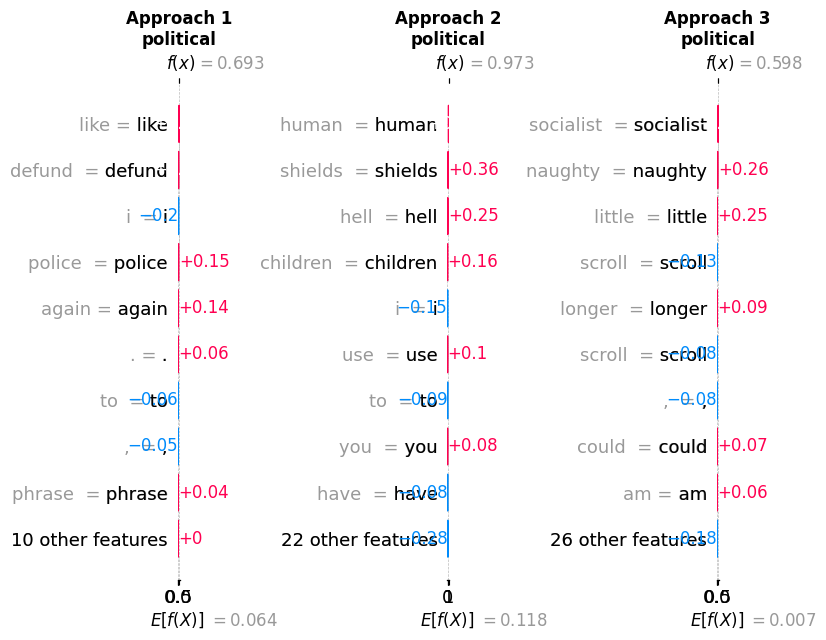


PROCESSING LABEL: gender/sexual
GENERATING SHAP VISUALIZATIONS FOR LABEL: gender/sexual

--- APPROACH 1 ---
Example text: thats a translation of zelensky fuckface...

Creating SHAP visualization for Approach_1 - gender/sexual
Saved: Approach_1_SHAP_gender_sexual_detailed.png

--- APPROACH 2 ---
Example text: i dunno but i can tell you hell use his children as human shields so in a way he does technically ha...

Creating SHAP visualization for Approach_2 - gender/sexual


  0%|          | 0/498 [00:00<?, ?it/s]

Saved: Approach_2_SHAP_gender_sexual_detailed.png

--- APPROACH 3 ---
Example text: if you are a liberal defending pedophilia because its part of the liberal agenda, you need to reread...

Creating SHAP visualization for Approach_3 - gender/sexual
Saved: Approach_3_SHAP_gender_sexual_detailed.png
GENERATING WATERFALL PLOTS FOR LABEL: gender/sexual


  0%|          | 0/498 [00:00<?, ?it/s]

/tmp/ipython-input-4202430071.py:272: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


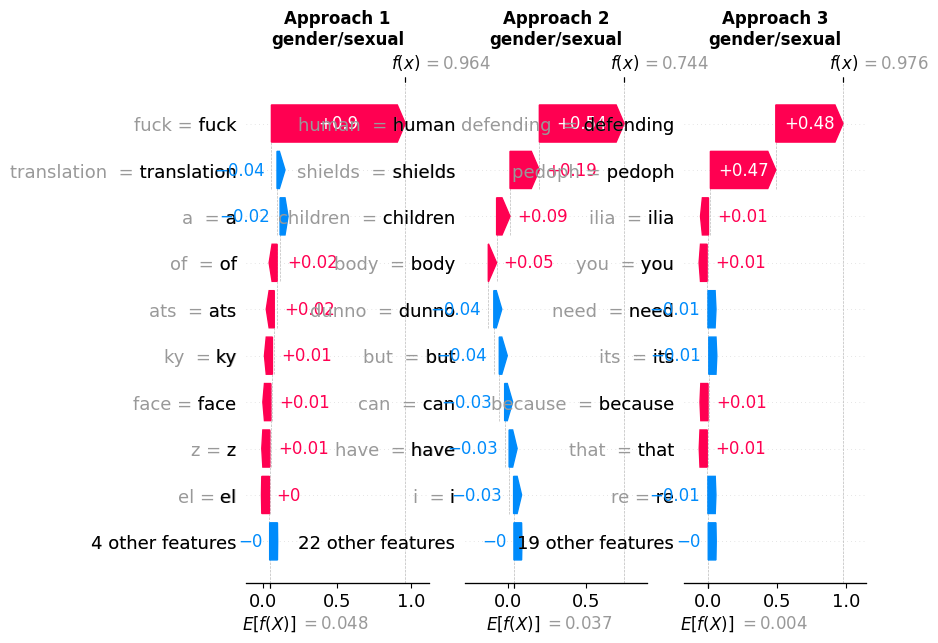

In [32]:
# ============================================================
# DETAILED SHAP VISUALIZATIONS FOR ALL APPROACHES
# ============================================================

import shap
import matplotlib.pyplot as plt
import numpy as np
import torch

# ============================================================
# SHAP TEXT EXPLAINER WITH HIGHLIGHTED WORDS
# ============================================================

def create_shap_visualization(model, tokenizer, text, approach_name, label_name, device):
    """Create detailed SHAP visualization with highlighted text"""

    print(f"\nCreating SHAP visualization for {approach_name} - {label_name}")

    # Prepare prediction function
    def predict_fn(texts):
        if isinstance(texts, str):
            texts = [texts]

        probs = []
        for text in texts:
            encoding = tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors="pt"
            )
            encoding = {k: v.to(device) for k, v in encoding.items()}

            with torch.no_grad():
                logits = model(**encoding).logits

                if logits.shape[1] == 2:
                    prob = torch.softmax(logits, dim=1)[0, 1].item()
                else:
                    prob = torch.sigmoid(logits)[0, 0].item()

            probs.append(prob)

        return np.array(probs)

    # Create SHAP explainer
    masker = shap.maskers.Text(tokenizer)
    explainer = shap.Explainer(predict_fn, masker)

    # Get SHAP values
    shap_values = explainer([text])

    # Create figure with two subplots
    fig = plt.figure(figsize=(16, 6))

    # Subplot 1: Bar plot of word importances
    ax1 = plt.subplot(1, 2, 1)

    # Extract words and their SHAP values
    words = shap_values.data[0]
    values = shap_values.values[0]

    # Sort by absolute values
    indices = np.argsort(np.abs(values))[-15:]  # Top 15 words
    sorted_words = [words[i] for i in indices]
    sorted_values = [values[i] for i in indices]

    # Create bar plot
    colors = ['#FF6B6B' if v < 0 else '#4ECDC4' for v in sorted_values]
    bars = ax1.barh(range(len(sorted_words)), sorted_values, color=colors, alpha=0.7)
    ax1.set_yticks(range(len(sorted_words)))
    ax1.set_yticklabels(sorted_words, fontsize=10)
    ax1.set_xlabel('SHAP Value', fontsize=12, fontweight='bold')
    ax1.set_title(f'{approach_name} - Feature Importance\n{label_name}',
                  fontsize=13, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax1.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, sorted_values)):
        x_pos = bar.get_width()
        ax1.text(x_pos + 0.01 if x_pos > 0 else x_pos - 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{val:.3f}',
                ha='left' if x_pos > 0 else 'right',
                va='center',
                fontsize=9)

    # Subplot 2: Highlighted text
    ax2 = plt.subplot(1, 2, 2)
    ax2.axis('off')

    # Create highlighted text
    highlighted_text = create_highlighted_text(words, values)

    # Add prediction info
    pred_prob = predict_fn(text)[0]
    pred_label = "Polarized" if pred_prob >= 0.5 else "Non-polarized"

    info_text = f"Prediction: {pred_label}\nProbability: {pred_prob:.3f}\n\n"

    ax2.text(0.05, 0.95, info_text,
            transform=ax2.transAxes,
            fontsize=11,
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    # Add highlighted text
    ax2.text(0.05, 0.75, "Text with highlighted words:",
            transform=ax2.transAxes,
            fontsize=11,
            fontweight='bold',
            verticalalignment='top')

    ax2.text(0.05, 0.05, highlighted_text,
            transform=ax2.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            wrap=True)

    plt.tight_layout()

    # FIX: Sanitize filename by replacing '/' with '_'
    safe_label_name = label_name.replace('/', '_')
    filename = f'{approach_name}_SHAP_{safe_label_name}_detailed.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved: {filename}")
    plt.close()

    return shap_values

def create_highlighted_text(words, values, threshold=0.05):
    """Create text with color-coded highlighting based on SHAP values"""

    # Normalize values for color intensity
    max_abs_value = max(abs(np.max(values)), abs(np.min(values)))

    highlighted = []
    for word, value in zip(words, values):
        if abs(value) > threshold:
            if value > 0:
                # Positive contribution (blue/orange)
                intensity = min(abs(value) / max_abs_value, 1.0)
                highlighted.append(f"[{word}↑{value:.2f}]")
            else:
                # Negative contribution (red)
                intensity = min(abs(value) / max_abs_value, 1.0)
                highlighted.append(f"[{word}↓{value:.2f}]")
        else:
            highlighted.append(word)

    return " ".join(highlighted)

# ============================================================
# GENERATE VISUALIZATIONS FOR EACH APPROACH
# ============================================================

def generate_all_shap_visualizations(bad_preds_dict, label='political'):
    """Generate SHAP visualizations for all approaches"""

    print("="*70)
    print(f"GENERATING SHAP VISUALIZATIONS FOR LABEL: {label}")
    print("="*70)

    # Get a false positive example for this label

    # APPROACH 1
    if A1_bad_preds[label]['fp_texts']:
        text = A1_bad_preds[label]['fp_texts'][0]

        model_map = {
            'political': A1_trainer_m1.model,
            'racial/ethnic': A1_trainer_m1.model,
            'religious': A1_trainer_m1.model,
            'gender/sexual': A1_trainer_m2.model,
            'other': A1_trainer_m3.model
        }

        model = model_map[label]

        print(f"\n--- APPROACH 1 ---")
        print(f"Example text: {text[:100]}...")

        create_shap_visualization(
            model, A1_tokenizer, text,
            'Approach_1', label, device
        )

    # APPROACH 2
    if A2_bad_preds[label]['fp_texts']:
        text = A2_bad_preds[label]['fp_texts'][0]

        if label == 'political':
            model = A2_trainer_m1.model
        else:
            model = A2_trainer_m2.model

        print(f"\n--- APPROACH 2 ---")
        print(f"Example text: {text[:100]}...")

        create_shap_visualization(
            model, A2_tokenizer, text,
            'Approach_2', label, device
        )

    # APPROACH 3
    if A3_bad_preds[label]['fp_texts']:
        text = A3_bad_preds[label]['fp_texts'][0]
        model = A3_models[label]

        print(f"\n--- APPROACH 3 ---")
        print(f"Example text: {text[:100]}...")

        create_shap_visualization(
            model, A3_tokenizer, text,
            'Approach_3', label, device
        )

# ============================================================
# ALTERNATIVE: SHAP WATERFALL PLOTS
# ============================================================

def create_waterfall_plots(bad_preds_dict, label='political'):
    """Create SHAP waterfall plots for comparison"""

    print("="*70)
    print(f"GENERATING WATERFALL PLOTS FOR LABEL: {label}")
    print("="*70)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    approaches = [
        ('Approach 1', A1_bad_preds, A1_trainer_m1.model, A1_tokenizer),
        ('Approach 2', A2_bad_preds, A2_trainer_m1.model if label == 'political' else A2_trainer_m2.model, A2_tokenizer),
        ('Approach 3', A3_bad_preds, A3_models[label], A3_tokenizer)
    ]

    for idx, (name, bad_preds, model, tokenizer) in enumerate(approaches):
        if bad_preds[label]['fp_texts']:
            text = bad_preds[label]['fp_texts'][0]

            # Prediction function
            def predict_fn(texts):
                if isinstance(texts, str):
                    texts = [texts]
                probs = []
                for t in texts:
                    encoding = tokenizer(t, truncation=True, padding=True,
                                       max_length=128, return_tensors="pt")
                    encoding = {k: v.to(device) for k, v in encoding.items()}
                    with torch.no_grad():
                        logits = model(**encoding).logits
                        if logits.shape[1] == 2:
                            prob = torch.softmax(logits, dim=1)[0, 1].item()
                        else:
                            prob = torch.sigmoid(logits)[0, 0].item()
                    probs.append(prob)
                return np.array(probs)

            # Create explainer
            masker = shap.maskers.Text(tokenizer)
            explainer = shap.Explainer(predict_fn, masker)
            shap_values = explainer([text])

            # Plot waterfall
            plt.sca(axes[idx])
            shap.plots.waterfall(shap_values[0], max_display=10, show=False)
            axes[idx].set_title(f'{name}\n{label}', fontsize=12, fontweight='bold')

    plt.tight_layout()
    # FIX: Sanitize filename
    safe_label = label.replace('/', '_')
    plt.savefig(f'Waterfall_Comparison_{safe_label}.png', dpi=150, bbox_inches='tight')
    plt.show()
    #print(f"Saved: Waterfall_Comparison_{safe_label}.png")
    plt.close()

# ============================================================
# EXECUTION
# ============================================================

print("="*70)
print("CREATING DETAILED SHAP VISUALIZATIONS")
print("="*70)

# Ensure bad predictions are identified
print("\n--- Identifying Bad Predictions ---")
A1_bad_preds = identify_bad_predictions(
    val, A1_combined_preds, A1_combined_labels, A1_label_cols, top_n=10
)
A2_bad_preds = identify_bad_predictions(
    val, A2_combined_preds, A2_combined_labels, A2_label_cols, top_n=10
)
A3_bad_preds = identify_bad_predictions(
    val, A3_combined_preds, A3_combined_labels, A3_label_cols, top_n=10
)

# Generate visualizations for each label
for label in ['political', 'gender/sexual']:  # Can add more labels
    print(f"\n{'='*70}")
    print(f"PROCESSING LABEL: {label}")
    print(f"{'='*70}")

    generate_all_shap_visualizations(
        {'A1': A1_bad_preds, 'A2': A2_bad_preds, 'A3': A3_bad_preds},
        label=label
    )

    # Optional: Create waterfall comparison
    create_waterfall_plots(
        {'A1': A1_bad_preds, 'A2': A2_bad_preds, 'A3': A3_bad_preds},
        label=label
    )
